In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [ ]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 120655493.45it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 79070296.23it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35761185.35it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13607520.55it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Define the CNN model with Tanh activation in hidden layers and output layer
class CNNleakyrelu(nn.Module):
    def __init__(self):
        super(CNNleakyrelu, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 3 * 3, 128)  # Adjust the input size based on your input image dimensions
        self.fc2 = nn.Linear(128, 10)  # 10 output classes for MNIST

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3)  # Reshape before passing to fully connected layers
        x = nn.functional.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.fc2(x)
        return x


In [ ]:
# new code 1

# Choose a percentage of samples for the small dataset
small_dataset_percentage = 0.1  # You can adjust this value

small_train_size = int(small_dataset_percentage * len(train_dataset))
small_test_size = int(small_dataset_percentage * len(test_dataset))

small_train_dataset = torch.utils.data.Subset(train_dataset, range(small_train_size))
small_test_dataset = torch.utils.data.Subset(test_dataset, range(small_test_size))

small_train_loader = torch.utils.data.DataLoader(dataset=small_train_dataset, batch_size=64, shuffle=True)
small_test_loader = torch.utils.data.DataLoader(dataset=small_test_dataset, batch_size=64, shuffle=False)


Epoch [1/10], Train Accuracy: 0.9530, Test Accuracy: 0.9210
Epoch [2/10], Train Accuracy: 0.9658, Test Accuracy: 0.9470
Epoch [3/10], Train Accuracy: 0.9795, Test Accuracy: 0.9680
Epoch [4/10], Train Accuracy: 0.9853, Test Accuracy: 0.9610
Epoch [5/10], Train Accuracy: 0.9632, Test Accuracy: 0.9300
Epoch [6/10], Train Accuracy: 0.9947, Test Accuracy: 0.9730
Epoch [7/10], Train Accuracy: 0.9883, Test Accuracy: 0.9670
Epoch [8/10], Train Accuracy: 0.9947, Test Accuracy: 0.9720
Epoch [9/10], Train Accuracy: 0.9957, Test Accuracy: 0.9750
Epoch [10/10], Train Accuracy: 0.9973, Test Accuracy: 0.9800


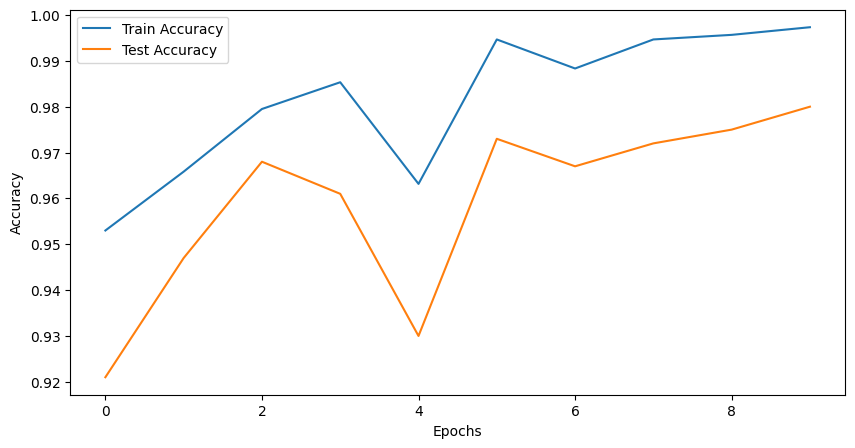

In [ ]:
# new code 2
# Instantiate the model
small_model = CNNleakyrelu()
small_criterion = nn.CrossEntropyLoss()
small_optimizer = optim.Adam(small_model.parameters(), lr=0.001)

# Training the model on the small dataset
small_num_epochs = 10
small_train_losses = []
small_test_losses = []
small_train_accuracies = []
small_test_accuracies = []

for epoch in range(small_num_epochs):
    small_model.train()  # Set the model to training mode
    for i, (images, labels) in enumerate(small_train_loader):
        # Forward pass
        small_outputs = small_model(images)
        small_loss = small_criterion(small_outputs, labels)

        # Backward pass and optimization
        small_optimizer.zero_grad()
        small_loss.backward()
        small_optimizer.step()

    # Evaluate on the training set
    small_model.eval()
    small_train_preds = []
    small_train_labels = []
    with torch.no_grad():
        for images, labels in small_train_loader:
            small_outputs = small_model(images)
            _, small_train_predicted = torch.max(small_outputs.data, 1)
            small_train_preds.extend(small_train_predicted.numpy())
            small_train_labels.extend(labels.numpy())

    small_train_accuracy = accuracy_score(small_train_labels, small_train_preds)
    small_train_losses.append(small_loss.item())
    small_train_accuracies.append(small_train_accuracy)

    # Evaluate on the test set
    small_test_preds = []
    small_test_labels = []
    with torch.no_grad():
        for images, labels in small_test_loader:
            small_outputs = small_model(images)
            _, small_test_predicted = torch.max(small_outputs.data, 1)
            small_test_preds.extend(small_test_predicted.numpy())
            small_test_labels.extend(labels.numpy())

    small_test_accuracy = accuracy_score(small_test_labels, small_test_preds)
    small_test_loss = small_criterion(small_outputs, labels).item()
    small_test_losses.append(small_test_loss)
    small_test_accuracies.append(small_test_accuracy)

    # Print training statistics
    print('Epoch [{}/{}], Train Accuracy: {:.4f}, Test Accuracy: {:.4f}'.format(epoch + 1, small_num_epochs, small_train_accuracy, small_test_accuracy))

# Plot training and test accuracies
plt.figure(figsize=(10, 5))
plt.plot(small_train_accuracies, label='Train Accuracy')
plt.plot(small_test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


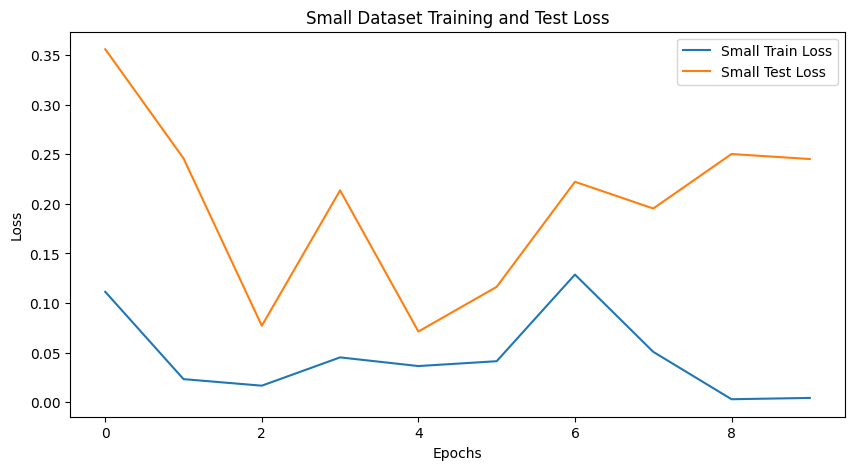

In [ ]:
# new code 3
# After the small dataset training loop
plt.figure(figsize=(10, 5))
plt.plot(small_train_losses, label='Small Train Loss')
plt.plot(small_test_losses, label='Small Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Small Dataset Training and Test Loss')
plt.show()


In [ ]:
# new code 4
# After the small dataset training loop
small_test_precision = precision_score(small_test_labels, small_test_preds, average='weighted')
small_test_recall = recall_score(small_test_labels, small_test_preds, average='weighted')
small_test_f1 = f1_score(small_test_labels, small_test_preds, average='weighted')

print("Small Dataset Metrics:")
print("Test Accuracy: {:.4f}".format(small_test_accuracy))
print("Test Precision: {:.4f}".format(small_test_precision))
print("Test Recall: {:.4f}".format(small_test_recall))
print("Test F1 Score: {:.4f}".format(small_test_f1))


Small Dataset Metrics:
Test Accuracy: 0.9800
Test Precision: 0.9803
Test Recall: 0.9800
Test F1 Score: 0.9800


In [ ]:
# new code 5
# Load a large subset of the MNIST dataset
large_dataset_percentage = 0.7  # You can adjust this value

large_train_size = int(large_dataset_percentage * len(train_dataset))
large_test_size = int(large_dataset_percentage * len(test_dataset))

large_train_dataset = torch.utils.data.Subset(train_dataset, range(large_train_size))
large_test_dataset = torch.utils.data.Subset(test_dataset, range(large_test_size))

large_train_loader = torch.utils.data.DataLoader(dataset=large_train_dataset, batch_size=64, shuffle=True)
large_test_loader = torch.utils.data.DataLoader(dataset=large_test_dataset, batch_size=64, shuffle=False)

# Instantiate the model for the large dataset
large_model = CNNleakyrelu()

# Define criterion and optimizer for the large dataset
large_criterion = nn.CrossEntropyLoss()
large_optimizer = optim.Adam(large_model.parameters(), lr=0.001)


Epoch [1/10], Large Train Accuracy: 0.9844, Large Test Accuracy: 0.9823
Epoch [2/10], Large Train Accuracy: 0.9879, Large Test Accuracy: 0.9830
Epoch [3/10], Large Train Accuracy: 0.9948, Large Test Accuracy: 0.9889
Epoch [4/10], Large Train Accuracy: 0.9947, Large Test Accuracy: 0.9887
Epoch [5/10], Large Train Accuracy: 0.9963, Large Test Accuracy: 0.9886
Epoch [6/10], Large Train Accuracy: 0.9972, Large Test Accuracy: 0.9896
Epoch [7/10], Large Train Accuracy: 0.9964, Large Test Accuracy: 0.9869
Epoch [8/10], Large Train Accuracy: 0.9975, Large Test Accuracy: 0.9894
Epoch [9/10], Large Train Accuracy: 0.9971, Large Test Accuracy: 0.9899
Epoch [10/10], Large Train Accuracy: 0.9989, Large Test Accuracy: 0.9913


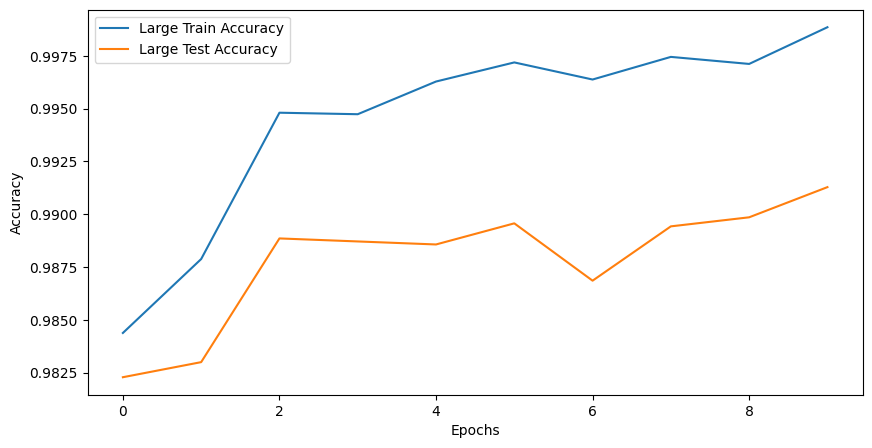

In [ ]:
# new code 6
# Training the model on the large dataset
large_num_epochs = 10
large_train_losses = []
large_test_losses = []
large_train_accuracies = []
large_test_accuracies = []

for epoch in range(large_num_epochs):
    large_model.train()
    for i, (images, labels) in enumerate(large_train_loader):
        large_outputs = large_model(images)
        large_loss = large_criterion(large_outputs, labels)
        large_optimizer.zero_grad()
        large_loss.backward()
        large_optimizer.step()

    # Evaluate on the training set
    large_model.eval()
    large_train_preds = []
    large_train_labels = []
    with torch.no_grad():
        for images, labels in large_train_loader:
            large_outputs = large_model(images)
            _, large_train_predicted = torch.max(large_outputs.data, 1)
            large_train_preds.extend(large_train_predicted.numpy())
            large_train_labels.extend(labels.numpy())

    large_train_accuracy = accuracy_score(large_train_labels, large_train_preds)
    large_train_losses.append(large_loss.item())
    large_train_accuracies.append(large_train_accuracy)

    # Evaluate on the test set
    large_test_preds = []
    large_test_labels = []
    with torch.no_grad():
        for images, labels in large_test_loader:
            large_outputs = large_model(images)
            _, large_test_predicted = torch.max(large_outputs.data, 1)
            large_test_preds.extend(large_test_predicted.numpy())
            large_test_labels.extend(labels.numpy())

    large_test_accuracy = accuracy_score(large_test_labels, large_test_preds)
    large_test_loss = large_criterion(large_outputs, labels).item()
    large_test_losses.append(large_test_loss)
    large_test_accuracies.append(large_test_accuracy)

    print('Epoch [{}/{}], Large Train Accuracy: {:.4f}, Large Test Accuracy: {:.4f}'.format(epoch + 1, large_num_epochs, large_train_accuracy, large_test_accuracy))

# Plot training and test accuracies for the large dataset
plt.figure(figsize=(10, 5))
plt.plot(large_train_accuracies, label='Large Train Accuracy')
plt.plot(large_test_accuracies, label='Large Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


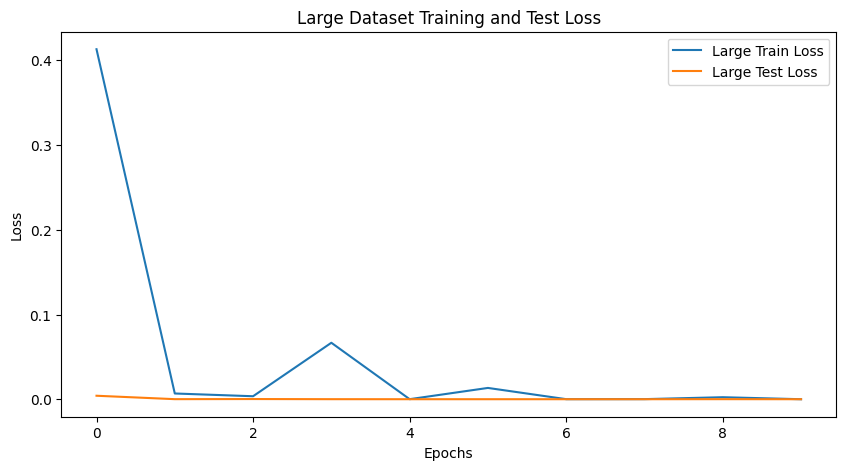

In [ ]:
# new code 7
# After the large dataset training loop
plt.figure(figsize=(10, 5))
plt.plot(large_train_losses, label='Large Train Loss')
plt.plot(large_test_losses, label='Large Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Large Dataset Training and Test Loss')
plt.show()


In [ ]:
# new code 8
# After the large dataset training loop
large_test_precision = precision_score(large_test_labels, large_test_preds, average='weighted')
large_test_recall = recall_score(large_test_labels, large_test_preds, average='weighted')
large_test_f1 = f1_score(large_test_labels, large_test_preds, average='weighted')

print("Large Dataset Metrics:")
print("Test Accuracy: {:.4f}".format(large_test_accuracy))
print("Test Precision: {:.4f}".format(large_test_precision))
print("Test Recall: {:.4f}".format(large_test_recall))
print("Test F1 Score: {:.4f}".format(large_test_f1))


Large Dataset Metrics:
Test Accuracy: 0.9913
Test Precision: 0.9913
Test Recall: 0.9913
Test F1 Score: 0.9913


In [ ]:
# new code 9
# Instantiate the model for the full dataset
full_model = CNNleakyrelu()

# Define criterion and optimizer for the full dataset
full_criterion = nn.CrossEntropyLoss()
full_optimizer = optim.Adam(full_model.parameters(), lr=0.001)



Epoch [1/10], Full Train Accuracy: 0.9850, Full Test Accuracy: 0.9861
Epoch [2/10], Full Train Accuracy: 0.9899, Full Test Accuracy: 0.9881
Epoch [3/10], Full Train Accuracy: 0.9956, Full Test Accuracy: 0.9919
Epoch [4/10], Full Train Accuracy: 0.9933, Full Test Accuracy: 0.9880
Epoch [5/10], Full Train Accuracy: 0.9939, Full Test Accuracy: 0.9897
Epoch [6/10], Full Train Accuracy: 0.9938, Full Test Accuracy: 0.9901
Epoch [7/10], Full Train Accuracy: 0.9975, Full Test Accuracy: 0.9916
Epoch [8/10], Full Train Accuracy: 0.9977, Full Test Accuracy: 0.9923
Epoch [9/10], Full Train Accuracy: 0.9979, Full Test Accuracy: 0.9920
Epoch [10/10], Full Train Accuracy: 0.9970, Full Test Accuracy: 0.9910


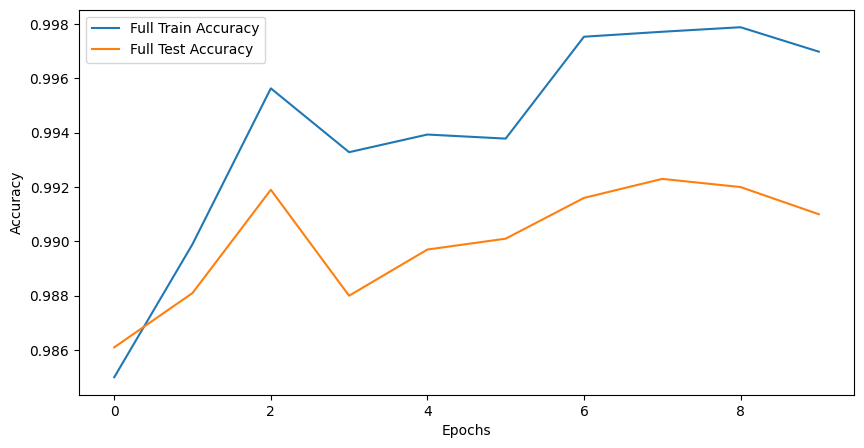

In [ ]:
# new code 10
# Training the model on the full dataset
full_num_epochs = 10
full_train_losses = []
full_test_losses = []
full_train_accuracies = []
full_test_accuracies = []

for epoch in range(full_num_epochs):
    full_model.train()
    for i, (images, labels) in enumerate(train_loader):
        full_outputs = full_model(images)
        full_loss = full_criterion(full_outputs, labels)
        full_optimizer.zero_grad()
        full_loss.backward()
        full_optimizer.step()

    # Evaluate on the training set
    full_model.eval()
    full_train_preds = []
    full_train_labels = []
    with torch.no_grad():
        for images, labels in train_loader:
            full_outputs = full_model(images)
            _, full_train_predicted = torch.max(full_outputs.data, 1)
            full_train_preds.extend(full_train_predicted.numpy())
            full_train_labels.extend(labels.numpy())

    full_train_accuracy = accuracy_score(full_train_labels, full_train_preds)
    full_train_losses.append(full_loss.item())
    full_train_accuracies.append(full_train_accuracy)

    # Evaluate on the test set
    full_test_preds = []
    full_test_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            full_outputs = full_model(images)
            _, full_test_predicted = torch.max(full_outputs.data, 1)
            full_test_preds.extend(full_test_predicted.numpy())
            full_test_labels.extend(labels.numpy())

    full_test_accuracy = accuracy_score(full_test_labels, full_test_preds)
    full_test_loss = full_criterion(full_outputs, labels).item()
    full_test_losses.append(full_test_loss)
    full_test_accuracies.append(full_test_accuracy)

    print('Epoch [{}/{}], Full Train Accuracy: {:.4f}, Full Test Accuracy: {:.4f}'.format(epoch + 1, full_num_epochs, full_train_accuracy, full_test_accuracy))

# Plot training and test accuracies for the full dataset
plt.figure(figsize=(10, 5))
plt.plot(full_train_accuracies, label='Full Train Accuracy')
plt.plot(full_test_accuracies, label='Full Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


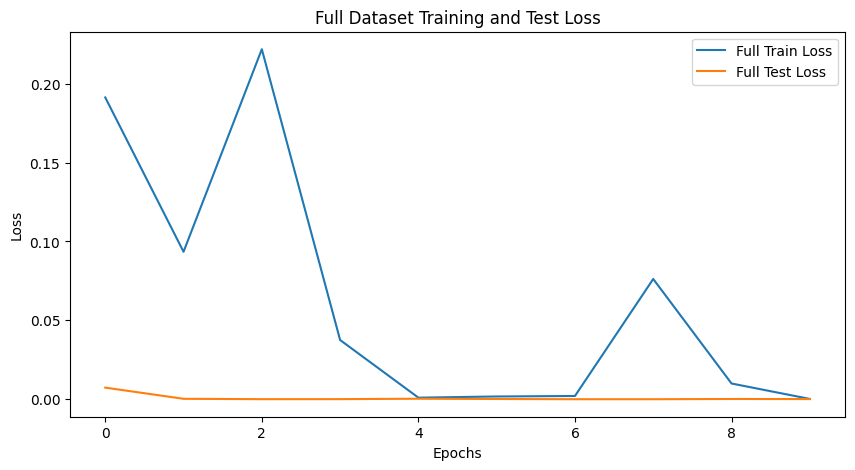

In [ ]:
# new code 11
# After the full dataset training loop
plt.figure(figsize=(10, 5))
plt.plot(full_train_losses, label='Full Train Loss')
plt.plot(full_test_losses, label='Full Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Full Dataset Training and Test Loss')
plt.show()



In [ ]:
# new code 12
# After the full dataset training loop
full_test_precision = precision_score(full_test_labels, full_test_preds, average='weighted')
full_test_recall = recall_score(full_test_labels, full_test_preds, average='weighted')
full_test_f1 = f1_score(full_test_labels, full_test_preds, average='weighted')

print("Full Dataset Metrics:")
print("Test Accuracy: {:.4f}".format(full_test_accuracy))
print("Test Precision: {:.4f}".format(full_test_precision))
print("Test Recall: {:.4f}".format(full_test_recall))
print("Test F1 Score: {:.4f}".format(full_test_f1))


Full Dataset Metrics:
Test Accuracy: 0.9910
Test Precision: 0.9910
Test Recall: 0.9910
Test F1 Score: 0.9910


In [ ]:
# do not run

# Create an instance of the CNN model with leakyrelu activation
model_leakyrelu= CNNleakyrelu()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification problems
optimizer = optim.Adam(model_leakyrelu.parameters(), lr=0.001)  # Adam optimizer

# Training the model
num_epochs = 10  # Number of training epochs
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model_leakyrelu(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training statistics
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

# Test the model
model_leakyrelu.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model_leakyrelu(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model with leaky relu activation: {:.2f} %'.format(100 * correct / total))

Epoch [1/10], Step [100/938], Loss: 0.1729
Epoch [1/10], Step [200/938], Loss: 0.2752
Epoch [1/10], Step [300/938], Loss: 0.0221
Epoch [1/10], Step [400/938], Loss: 0.0209
Epoch [1/10], Step [500/938], Loss: 0.0470
Epoch [1/10], Step [600/938], Loss: 0.0716
Epoch [1/10], Step [700/938], Loss: 0.1373
Epoch [1/10], Step [800/938], Loss: 0.0186
Epoch [1/10], Step [900/938], Loss: 0.0144
Epoch [2/10], Step [100/938], Loss: 0.0312
Epoch [2/10], Step [200/938], Loss: 0.0564
Epoch [2/10], Step [300/938], Loss: 0.0820
Epoch [2/10], Step [400/938], Loss: 0.1200
Epoch [2/10], Step [500/938], Loss: 0.0121
Epoch [2/10], Step [600/938], Loss: 0.0510
Epoch [2/10], Step [700/938], Loss: 0.0132
Epoch [2/10], Step [800/938], Loss: 0.0052
Epoch [2/10], Step [900/938], Loss: 0.0071
Epoch [3/10], Step [100/938], Loss: 0.0026
Epoch [3/10], Step [200/938], Loss: 0.0151
Epoch [3/10], Step [300/938], Loss: 0.0113
Epoch [3/10], Step [400/938], Loss: 0.0118
Epoch [3/10], Step [500/938], Loss: 0.0370
Epoch [3/10